# 2.0. Importing Libraries

In [1]:
import pandas  as pd
import numpy   as np

from sklearn.metrics.pairwise import nan_euclidean_distances

import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns
import pdb
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import layers
from sklearn.metrics  import mean_absolute_error
from sklearn.metrics  import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

# 3.0. Data Paths

In [3]:
path = "../data/final_data.csv"

# 4.0. Plot Patterns

In [4]:
colors = {
  "color_north": "#B4C4DF",
  "color_east" : "#FFF7FB",
  "color_west" : "#258BAE",
  "color_south": "#014636",
}

cmap = "PuBuGn"

In [5]:
mpl.rcParams['figure.figsize'] = (18, 8)

In [6]:
sns.set_theme()

# 5.0. Auxiliar Functions

In [7]:
def month_rename(month):
  month_dict = {
    "Janeiro": "Jan",
    "Fevereiro": "Feb",
    "Março": "Mar",
    "Abril": "Apr",
    "Maio": "May",
    "Junho": "June",
    "Julho": "July",
    "Agosto": "Aug",
    "Setembro": "Sep",
    "Outubro": "Oct",
    "Novembro": "Nov",
    "Dezembro": "Dec"
  }

  return month_dict.get(month, "")

def district_rename(district):
  district_dict = {
    "Norte": "North",
    "Norte 1": "North",
    "Norte 2": "North",
    "Sul": "South",
    "Leste": "East",
    "Oeste": "West",
  }

  return district_dict.get(district, "")

def Get_ReorderTraps(eDist, NNeigh):
  # Here we order traps by proximity, return the NNeigh traps for each one
  cnt_Trap = 0
  Current_Trap = 0
  N = len(eDist)
  Ordered_Traps =  np.array(0, dtype=np.uint16)
  Neigh_Traps =  np.zeros((N,NNeigh), dtype=np.uint16)
  Sort_Dist =  np.zeros((N,NNeigh), dtype=np.float16)

  while cnt_Trap<(N-1):
    Dist = eDist[Current_Trap,:]
    #Dist = np.delete(Dist, Ordered_Traps)
    sortIndx = np.argsort(Dist)
    I = ~np.isin(sortIndx, Ordered_Traps)

    Neigh_Traps[cnt_Trap,:] = sortIndx[0:NNeigh]
    Sort_Dist[cnt_Trap,:] = Dist[sortIndx][0:NNeigh]
    cnt_Trap = cnt_Trap + 1

    Current_Trap = sortIndx[I][0]
    Ordered_Traps = np.append(Ordered_Traps, Current_Trap)

  Dist = eDist[Current_Trap,:]
  sortIndx = np.argsort(Dist)
  Neigh_Traps[cnt_Trap,:] = sortIndx[0:NNeigh]
  Sort_Dist[cnt_Trap,:] = Dist[sortIndx][0:NNeigh]
  return Ordered_Traps, Neigh_Traps, Sort_Dist

def create_ovitraps_matrix(ovitraps_dataframe):
  n_ids   = len(ovitraps_dataframe['ID'].unique())
  n_weeks = 0

  for yr in ovitraps_dataframe['Yr'].unique():
    n_weeks += len(ovitraps_dataframe.query("Yr == @yr")['Week'].unique())

  ovitraps_matrix = np.empty([n_weeks, n_ids])

  for i, id in enumerate(ovitraps_dataframe["ID"].unique()):
    ovitraps_matrix[:, i] = ovitraps_dataframe[ovitraps_dataframe["ID"] == id]["Eggs"]

  return ovitraps_matrix

def create_time_series(data_series, start_year, end_year):
  num_years  = end_year - start_year
  time_index = pd.date_range(f"{start_year}", f"{end_year + 1}", freq="W-FRI").date
  time_index = np.delete(time_index, 0)

  time_series       = data_series
  time_series.index = time_index

  return time_series

def weight_vector(x, w):
  p = x * w
  y = np.nanmean(p)

  return y

def spatial_smoothing(data, neigh_traps, w_dist):
  n_samples, n_traps = data.shape
  ordered_traps      = neigh_traps[:, 0]

  X = np.zeros((n_samples, n_traps), dtype=np.float16)

  for trap_idx in ordered_traps:
    traps   = neigh_traps[trap_idx,]
    weigths = w_dist[trap_idx,]

    for sample_idx in range(n_samples):
      x = data.iloc[sample_idx, traps]
      y = weight_vector(x, weigths)

      X[sample_idx, trap_idx] = y

  return X

def aggregate_values(X, traps):
  n_agg     = traps.shape[0]
  n_samples = X.shape[0]
  X_agg     = np.zeros((n_samples, n_agg), dtype=np.float32)

  for trap_idx in range(n_agg):
    traps_idx = traps[trap_idx,]

    for sample_idx in range(n_samples):
      X_agg[sample_idx, trap_idx] = np.nanmean(X[sample_idx, traps_idx])

  return X_agg

def create_random_series(training_matrix, number_of_points):
  sampled = training_matrix.sample(number_of_points)
  return sampled.mean().values

def create_dataset(series, week_shift):
  input, target = [], []

  for initial_week in range(series.shape[0] - week_shift + 1):
    data = series.iloc[initial_week : initial_week + week_shift]

    # Check if there are any NaN values in the data
    if data.isnull().values.any():
      continue
    input.append(data.iloc[:week_shift - 1])
    target.append(data.iloc[-1])

  return input, target

def split_train_test(input, target, train_size=0.7):
  train_lenght = int(len(target) * train_size)
  test_lenght  = int(len(target) * (1 - train_size))

  X_train = np.array(input[:train_lenght])
  X_test  = np.array(input[-(test_lenght + 1):])

  y_train = np.array(target[:train_lenght])
  y_test  = np.array(target[-(test_lenght + 1):])

  return X_train, X_test, y_train, y_test

def month_rename_pbh(month):
  month_dict = {
    8.0: "Jan",
    9.0: "Feb",
    10.0: "Mar",
    11.0: "Apr",
    12.0: "May",
    1.0: "June",
    2.0: "July",
    3.0: "Aug",
    4.0: "Sep",
    5.0: "Oct",
    6.0: "Nov",
    7.0: "Dec"
  }

  return month_dict.get(month, "")

def district_rename_pbh(district):
  district_dict = {
    "Norte": "North",
    "Norte 1": "North",
    "Norte 2": "North",
    "Sul": "South",
    "Leste": "East",
    "Oeste": "West",
  }

  return district_dict.get(district, "")
  
def AggregateTraps(Ordered_Traps, Loc, NNeigh):
  # Aggregate locations, return centroids and Traps used to aggregate
  NTraps = len(Loc)
  NCent = np.uint8(NTraps/NNeigh)
  Cent = np.zeros((NCent,2),dtype=np.float32)
  Traps = np.zeros((NCent,NNeigh),dtype=np.uint16)

  #Current_Cent = Loc[Current_Trap,].reshape(1,2)
  for iCent in range(NCent):
    I = np.arange(iCent*NNeigh,(iCent+1)*NNeigh)
    # select the closest NNeighborhoods to current trap
    Closest_Traps = Ordered_Traps[I]
    Traps[iCent,] = Closest_Traps
    # Update current centroid
    Current_Cent = np.mean(Loc[Closest_Traps,], axis=0).reshape(1,2)
    Cent[iCent,] = Current_Cent

  return Cent, Traps

Model Functions

In [8]:
def train_model(random_dataframe, model_function, model_function_args ,NUM_EPOCHS=1000,verbose=0,best_model=0,save_results=True, train_size=0.8):
    
  for column in random_dataframe.columns:
    random_series = random_dataframe.iloc[:, column]
    # input = 4-week window, target = 1-week value
    input, target = create_dataset(random_series, WEEK_SHIFT)

    X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=train_size)
    model = model_function(model_function_args)
    model.compile(loss="mse", optimizer="adam")

    if best_model:
      result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=NUM_EPOCHS, verbose=verbose)
    else:
      result = model.fit(X_train, y_train, epochs=NUM_EPOCHS, verbose=verbose)

    y_pred = result.model.predict(X_test)
    if save_results:
      error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
      error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))
      
    result.model.save(f"./models/{result.model.name}_{NUM_EPOCHS}_epochs_{column}.h5")
  return model, result, y_test, X_test, y_pred


def train_complex_naive(random_dataframe,save_results=True,train_size=0.8):
  for column in random_dataframe.columns:
    random_series = random_dataframe.iloc[:, column]
    # input = 4-week window, target = 1-week value
    input, target = create_dataset(random_series, WEEK_SHIFT)
    X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=train_size)
    y_pred = X_test[:, -1]
    if save_results:
      error_dataframe.loc['Naive', f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
      error_dataframe.loc['Naive', f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))
  return X_train, X_test, y_train, y_test, y_pred



def train_sarima_model(random_dataframe, save_results=True, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    """
    Train a SARIMA model and make predictions.
    """

    for column in random_dataframe.columns:
      random_series = random_dataframe.iloc[:, column]
      # input = 4-week window, target = 1-week value
      input, target = create_dataset(random_series, WEEK_SHIFT)
      X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)
      model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
      model = model.fit()
      # Initialize
      predictions = []
      # Recursive forecasting with state updates
      for t in y_test:
        pred = model.forecast(steps=1)
        predictions.append(pred[0])
        model = model.apply([t])
      y_pred = np.array(predictions)
      if save_results:
          error_dataframe.loc[ 'SARIMA', f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
          error_dataframe.loc[ 'SARIMA', f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))
      model.save(f"./models/SARIMA_{order}_{seasonal_order}_column_{column}.h5")
    return X_train, X_test, y_train, y_test, y_pred


def create_mlp_model(model_function_args):
  
  model_shape = model_function_args["model_shape"]
  model_name = model_function_args["model_name"]
  model = keras.Sequential([
      layers.Dense(model_shape[0], input_dim=WEEK_SHIFT-1, kernel_initializer="random_uniform", use_bias=True, activation="linear"),
      layers.Dense(model_shape[1], kernel_initializer="random_uniform", use_bias=True, activation="sigmoid"),
      layers.Dense(model_shape[2], kernel_initializer="random_uniform", use_bias=True, activation="linear"),
  ], name=model_name)

  return model


def create_lstm_model(model_function_args):
  model_shape = model_function_args["model_shape"]
  model_name = model_function_args["model_name"]
  if len(model_shape) == 2:
    model = keras.Sequential([
        layers.LSTM(model_shape[0], input_shape=(WEEK_SHIFT-1, 1), use_bias=True, activation="relu"),
        layers.Dense(model_shape[1], kernel_initializer="random_uniform", use_bias=True, activation="linear")
    ], name=model_name)

  elif len(model_shape) == 3:
    model = keras.Sequential([
      layers.LSTM(model_shape[0], input_shape=(WEEK_SHIFT-1, 1), use_bias=True, activation="relu", return_sequences=True),
      layers.LSTM(model_shape[1], use_bias=True, activation="relu"),
      layers.Dense(model_shape[2], kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name=model_name)

  return model


def create_gru_model(model_function_args):
  model_shape = model_function_args["model_shape"]
  model_name = model_function_args["model_name"]
  if len(model_shape) == 2:
    model = keras.Sequential([
      layers.GRU(model_shape[0], input_shape=(WEEK_SHIFT-1, 1), use_bias=True, activation="relu"),
      layers.Dense(model_shape[1], kernel_initializer="random_uniform", use_bias=True, activation="linear")
    ], name=model_name)

  elif len(model_shape) == 3:
    model = keras.Sequential([
      layers.GRU(model_shape[0], input_shape=(WEEK_SHIFT-1, 1), use_bias=True, activation="relu", return_sequences=True),
      layers.GRU(model_shape[1], use_bias=True, activation="relu"),
      layers.Dense(model_shape[2], kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name=model_name)

  return model


def results_plot(y_test, y_pred,naive, x_index, title, plot_naive=True):


  dates = pd.to_datetime(
      [f"{year}-W{week}-1" for year, week in x_index], format="%Y-W%W-%w"
  )
  
  # Get tick positions where the year changes
  years = [year for year, _ in x_index]
  tick_positions = [i for i in range(1, len(years)) if years[i] != years[i - 1]]
  tick_positions = [0] + tick_positions  # include the first point
  
  # Create tick labels from dates
  tick_labels = [dates[i].year for i in tick_positions]
  
  # Plotting
  plt.figure(figsize=(12, 6))
  plt.plot(y_test, label="True")
  plt.plot(y_pred, label="Predicted")
  if plot_naive:
    plt.plot(naive, label="Naive")
  plt.title(title, fontsize=20)
  plt.xlabel("Year", fontsize=14)
  plt.ylabel("Eggs Mean", fontsize=14)
  plt.xticks(tick_positions, tick_labels, rotation=45)
  plt.legend(fontsize=12)
  plt.grid(True)
  plt.tight_layout()
  plt.show()


def plot_loss(result, title ):
    fig, ax = plt.subplots()

    fig.suptitle(title, fontsize=20)

    ax.plot(result.history["loss"], label="Train")
    ax.plot(result.history["val_loss"], label="Validation")

    ax.set_ylabel("Loss", fontsize=14)
    ax.set_xlabel("Epoch", fontsize=14)

    ax.legend()
    plt.show()




# 6.0. Data Aquisition

To reproduce the results of this notebook, we should process PBH data to have the same format as the one used in the original paper. 

In [9]:
data = pd.read_csv(path)
data.head()

,exercicio,nplaca,narmad,idarmad,endarmad,cep,dtinstal,dtcol,semepi,cdabrange,...,longitude,coordx2,coordy2,zero_perc,Temperatura_week_bfr_mean,Precipitacao_week_bfr_mean,Umidade_week_bfr_mean,Temperatura_previsao,Precipitacao_previsao,Umidade_previsao
0,2018,90000140,901001,901374,97222,9.030691e+09,2018-06-18,2018-06-25,25,901460.0,...,-44.057499,598609.817,7791061.12,0.507246,19.808253,0.000220,68.661096,18.411880,0.000000,67.042419
1,2014,90000215,901001,901374,97222,9.030691e+09,2014-09-22,2014-09-29,39,901460.0,...,-44.057499,598609.817,7791061.12,0.612245,23.642767,1.129355,44.532898,23.126922,1.666262,43.045228
2,2023,90000156,901001,901374,97222,9.030691e+09,2023-05-29,2023-06-05,22,901460.0,...,-44.057499,598609.817,7791061.12,0.474308,18.503445,0.000220,69.176737,18.329463,0.008605,69.389451
3,2013,90000012,901001,901374,97222,9.030691e+09,2013-07-01,2013-07-08,27,901460.0,...,-44.057499,598609.817,7791061.12,0.650000,20.131793,3.002574,62.931308,18.455687,3.216737,59.702816
4,2015,90000272,901001,901374,97222,9.030691e+09,2015-03-30,2015-04-06,13,901460.0,...,-44.057499,598609.817,7791061.12,0.600000,22.886029,0.443180,71.087165,22.085876,0.703419,75.160273


## 6.1. Preprocessing

In [10]:
data.rename(columns={
    "exercicio": "Yr",
    "mesepid": "Month",
    "semepi": "Week",
    "distrito": "District",
    "nombairro": "Neighborhood",
    "idarmad": "ID",
    "novos": "Eggs",
    "latitude": "Lat",
    "longitude": "Lon"
},
    inplace=True
)
    
ovitraps_df = data[["Yr", "Month", "Week", "District", "Neighborhood", "ID", "Eggs", "Lat", "Lon"]]
ovitraps_df["Month"]    = ovitraps_df["Month"].apply(month_rename_pbh)
#ovitraps_df["District"] = ovitraps_df["District"].apply(district_rename_pbh)

In [11]:
data.head()

,Yr,nplaca,narmad,ID,endarmad,cep,dtinstal,dtcol,Week,cdabrange,...,Lon,coordx2,coordy2,zero_perc,Temperatura_week_bfr_mean,Precipitacao_week_bfr_mean,Umidade_week_bfr_mean,Temperatura_previsao,Precipitacao_previsao,Umidade_previsao
0,2018,90000140,901001,901374,97222,9.030691e+09,2018-06-18,2018-06-25,25,901460.0,...,-44.057499,598609.817,7791061.12,0.507246,19.808253,0.000220,68.661096,18.411880,0.000000,67.042419
1,2014,90000215,901001,901374,97222,9.030691e+09,2014-09-22,2014-09-29,39,901460.0,...,-44.057499,598609.817,7791061.12,0.612245,23.642767,1.129355,44.532898,23.126922,1.666262,43.045228
2,2023,90000156,901001,901374,97222,9.030691e+09,2023-05-29,2023-06-05,22,901460.0,...,-44.057499,598609.817,7791061.12,0.474308,18.503445,0.000220,69.176737,18.329463,0.008605,69.389451
3,2013,90000012,901001,901374,97222,9.030691e+09,2013-07-01,2013-07-08,27,901460.0,...,-44.057499,598609.817,7791061.12,0.650000,20.131793,3.002574,62.931308,18.455687,3.216737,59.702816
4,2015,90000272,901001,901374,97222,9.030691e+09,2015-03-30,2015-04-06,13,901460.0,...,-44.057499,598609.817,7791061.12,0.600000,22.886029,0.443180,71.087165,22.085876,0.703419,75.160273


### 6.1.1. Pivoting data

In [12]:
Mat = ovitraps_df.pivot(columns='ID', values='Eggs', index=['Yr','Week'] ).sort_index(axis=1, ascending=True)
Mat.head()

ID         900001  900003  900004  900005  900006  900007  900008  900009  \
Yr   Week                                                                   
2011 37       NaN     NaN     2.0     0.0     0.0     6.0     0.0     0.0   
     38      31.0     0.0     NaN     NaN     NaN     NaN     NaN     NaN   
     39       NaN     NaN     0.0     0.0     0.0   223.0     5.0     0.0   
     40       0.0     0.0     NaN     NaN     NaN     NaN     NaN     NaN   
     42       0.0     0.0     NaN     NaN     NaN     NaN     NaN     NaN   

ID         900010  900011  ...  902165  902167  902169  902170  902171  \
Yr   Week                  ...                                           
2011 37       0.0     0.0  ...     NaN     NaN     NaN     NaN     NaN   
     38       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
     39       0.0     0.0  ...     NaN     NaN     NaN     NaN     NaN   
     40       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
     42       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   

ID         902172  902173  902174  902183  902184  
Yr   Week                                          
2011 37       NaN     NaN     NaN     NaN     NaN  
     38       NaN     NaN     NaN     NaN     NaN  
     39       NaN     NaN     NaN     NaN     NaN  
     40       NaN     NaN     NaN     NaN     NaN  
     42       NaN     NaN     NaN     NaN     NaN  

[5 rows x 1773 columns]

#### 6.1.1.1 Index Analysis

In [13]:
index_df = Mat.index
index_df = pd.DataFrame(1, index=index_df, columns=['exists'])
index_df = index_df.reset_index()
pivoted_index = index_df.pivot_table(index='Yr', columns='Week', values='exists', fill_value='')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pivoted_index


Week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
Yr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.0,1.0,1.0,1.0,,1.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2012,1.0,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2013,,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2015,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### 6.1.1.2 Index Correction

In [14]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20) 

# Ensure index is clean
Mat.index = Mat.index.set_levels([Mat.index.levels[0].astype(int), Mat.index.levels[1].astype(int)])

# Step 1: Split
even_weeks = Mat[Mat.index.get_level_values('Week') % 2 == 0]
odd_weeks = Mat[Mat.index.get_level_values('Week') % 2 == 1]

# Step 2: Shift odd weeks
odd_weeks_shifted = odd_weeks.copy()
shifted_tuples = [(year, week + 1) for year, week in odd_weeks.index if week + 1 <= 52]
odd_weeks_shifted = odd_weeks.loc[[ix for ix in odd_weeks.index if ix[1] + 1 <= 52]]
odd_weeks_shifted.index = pd.MultiIndex.from_tuples(shifted_tuples, names=['Yr', 'Week'])

# Step 3: Combine
sum_df = odd_weeks_shifted + even_weeks
combined = sum_df.combine_first(odd_weeks_shifted)
combined = combined.combine_first(even_weeks)

# Assume your original DataFrame is called `df`
# and it uses the MultiIndex with ('Yr', 'Week')

# Step 1: Define year/week range from the existing index
start_year, start_week = combined.index[0]
end_year, end_week = combined.index[-1]

# Step 2: Generate new MultiIndex with odd weeks (3 to 51) per year within bounds
even_weeks_range = range(2, 53, 2)
new_tuples = [
    (year, week)
    for year in range(start_year, end_year + 1)
    for week in even_weeks_range
    if (year > start_year or week >= start_week) and (year < end_year or week <= end_week)
]

# Step 3: Combine with existing index and reindex the DataFrame
new_index = combined.index.union(pd.MultiIndex.from_tuples(new_tuples, names=["Yr", "Week"]))
Mat = combined.reindex(new_index).sort_index()


Mat

ID         900001  900003  900004  900005  900006  900007  900008  900009  \
Yr   Week                                                                   
2011 38      31.0     0.0     2.0     0.0     0.0     6.0     0.0     0.0   
     40       0.0     0.0     0.0     0.0     0.0   223.0     5.0     0.0   
     42       0.0     0.0     NaN     NaN     NaN     NaN     NaN     NaN   
     44       5.0     0.0     NaN     NaN     NaN     NaN     NaN     NaN   
     46      16.0     0.0     0.0     0.0     2.0    30.0    40.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2024 26       0.0     0.0    50.0    97.0    85.0   115.0    50.0     0.0   
     28       0.0     0.0    27.0     0.0     0.0     0.0     0.0     0.0   
     30       0.0    46.0    27.0     0.0     0.0     0.0     1.0   130.0   
     32       0.0     2.0    41.0     0.0   150.0     0.0    27.0     0.0   
     34       0.0     1.0     0.0     0.0     0.0     0.0     0.0   109.0   

ID         900010  900011  ...  902165  902167  902169  902170  902171  \
Yr   Week                  ...                                           
2011 38       0.0     0.0  ...     NaN     NaN     NaN     NaN     NaN   
     40       0.0     0.0  ...     NaN     NaN     NaN     NaN     NaN   
     42       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
     44       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
     46      34.0     0.0  ...     NaN     NaN     NaN     NaN     NaN   
...           ...     ...  ...     ...     ...     ...     ...     ...   
2024 26      46.0     0.0  ...    21.0     0.0   128.0     0.0     0.0   
     28       0.0     0.0  ...    31.0     0.0     0.0     0.0     0.0   
     30       0.0     0.0  ...     4.0     0.0     0.0     0.0     0.0   
     32       6.0     0.0  ...   161.0     0.0     0.0     0.0    10.0   
     34       0.0    59.0  ...    43.0     0.0     0.0     0.0    29.0   

ID         902172  902173  902174  902183  902184  
Yr   Week                                          
2011 38       NaN     NaN     NaN     NaN     NaN  
     40       NaN     NaN     NaN     NaN     NaN  
     42       NaN     NaN     NaN     NaN     NaN  
     44       NaN     NaN     NaN     NaN     NaN  
     46       NaN     NaN     NaN     NaN     NaN  
...           ...     ...     ...     ...     ...  
2024 26      69.0     0.0     0.0     0.0     0.0  
     28       0.0     0.0     0.0     NaN     0.0  
     30       0.0     0.0     0.0     NaN     0.0  
     32       0.0     0.0   116.0     0.0     0.0  
     34      37.0     0.0     0.0     0.0     0.0  

[337 rows x 1773 columns]

In [15]:
index_df = Mat.index
index_df = pd.DataFrame(1, index=index_df, columns=['exists'])
index_df = index_df.reset_index()
pivoted_index = index_df.pivot_table(index='Yr', columns='Week', values='exists', fill_value='')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pivoted_index


Week,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52
Yr,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,,,,,,,,,,,,,,,,,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2015,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
final_index = pd.to_datetime(
    [f'{year}-W{int(week):02d}-1' for year, week in Mat.index],
    format='%G-W%V-%u'
)

### 6.1.2. Eggs Data

In [17]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15) 


ovitraps_matrix= Mat
ovitraps_matrix_dataframe = pd.DataFrame(ovitraps_matrix)
ovitraps_matrix_dataframe

ID         900001  900003  900004  900005  900006  900007  900008  ...  \
Yr   Week                                                          ...   
2011 38      31.0     0.0     2.0     0.0     0.0     6.0     0.0  ...   
     40       0.0     0.0     0.0     0.0     0.0   223.0     5.0  ...   
     42       0.0     0.0     NaN     NaN     NaN     NaN     NaN  ...   
     44       5.0     0.0     NaN     NaN     NaN     NaN     NaN  ...   
     46      16.0     0.0     0.0     0.0     2.0    30.0    40.0  ...   
...           ...     ...     ...     ...     ...     ...     ...  ...   
2024 26       0.0     0.0    50.0    97.0    85.0   115.0    50.0  ...   
     28       0.0     0.0    27.0     0.0     0.0     0.0     0.0  ...   
     30       0.0    46.0    27.0     0.0     0.0     0.0     1.0  ...   
     32       0.0     2.0    41.0     0.0   150.0     0.0    27.0  ...   
     34       0.0     1.0     0.0     0.0     0.0     0.0     0.0  ...   

ID         902170  902171  902172  902173  902174  902183  902184  
Yr   Week                                                          
2011 38       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     40       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     42       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     44       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     46       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...           ...     ...     ...     ...     ...     ...     ...  
2024 26       0.0     0.0    69.0     0.0     0.0     0.0     0.0  
     28       0.0     0.0     0.0     0.0     0.0     NaN     0.0  
     30       0.0     0.0     0.0     0.0     0.0     NaN     0.0  
     32       0.0    10.0     0.0     0.0   116.0     0.0     0.0  
     34       0.0    29.0    37.0     0.0     0.0     0.0     0.0  

[337 rows x 1773 columns]

In [18]:
ovitraps_series = ovitraps_matrix_dataframe.mean(axis=1)
ovitraps_series

Yr    Week
2011  38       4.438538
      40      10.777409
      42       2.060498
      44       7.905138
      46      17.250000
                ...    
2024  26      20.341547
      28      16.557471
      30      14.435897
      32      12.580589
      34      16.673963
Length: 337, dtype: float64

In [19]:
ovitraps_series[ovitraps_series.isna()]

Yr    Week
2011  52     NaN
2012  8      NaN
      52     NaN
2013  52     NaN
2014  10     NaN
              ..
2022  8      NaN
      52     NaN
2023  8      NaN
      52     NaN
2024  6      NaN
Length: 20, dtype: float64

### 6.1.3. Eggs Hold Data (Median > 1)

In [20]:
y = np.nanstd(Mat, axis = 0)
x = np.nanmedian(Mat, axis = 0)
I = x > 1
ovitraps_matrix.median(axis=0)>1

ID
900001     True
900003     True
900004     True
900005     True
900006    False
          ...  
902172     True
902173    False
902174    False
902183    False
902184    False
Length: 1773, dtype: bool

In [21]:
ovitraps_matrix_hold           = ovitraps_matrix.iloc[:, I]
ovitraps_matrix_hold_dataframe = pd.DataFrame(ovitraps_matrix_hold)
ovitraps_matrix_hold_dataframe

ID         900001  900003  900004  900005  900008  900015  900016  ...  \
Yr   Week                                                          ...   
2011 38      31.0     0.0     2.0     0.0     0.0     0.0     0.0  ...   
     40       0.0     0.0     0.0     0.0     5.0     0.0     0.0  ...   
     42       0.0     0.0     NaN     NaN     NaN     0.0     NaN  ...   
     44       5.0     0.0     NaN     NaN     NaN     8.0     NaN  ...   
     46      16.0     0.0     0.0     0.0    40.0    57.0   112.0  ...   
...           ...     ...     ...     ...     ...     ...     ...  ...   
2024 26       0.0     0.0    50.0    97.0    50.0     0.0     0.0  ...   
     28       0.0     0.0    27.0     0.0     0.0     0.0     0.0  ...   
     30       0.0    46.0    27.0     0.0     1.0     0.0     0.0  ...   
     32       0.0     2.0    41.0     0.0    27.0     0.0     0.0  ...   
     34       0.0     1.0     0.0     0.0     0.0    41.0     2.0  ...   

ID         902159  902160  902162  902163  902165  902171  902172  
Yr   Week                                                          
2011 38       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     40       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     42       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     44       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
     46       NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...           ...     ...     ...     ...     ...     ...     ...  
2024 26     214.0     0.0    11.0     0.0    21.0     0.0    69.0  
     28     136.0     0.0     5.0     0.0    31.0     0.0     0.0  
     30     204.0     0.0     0.0   132.0     4.0     0.0     0.0  
     32       0.0     0.0     0.0     9.0   161.0    10.0     0.0  
     34      52.0     0.0     3.0    39.0    43.0    29.0    37.0  

[337 rows x 764 columns]

In [22]:
ovitraps_series_hold = ovitraps_matrix_hold_dataframe.mean(axis=1)
ovitraps_series_hold

Yr    Week
2011  38       5.877551
      40      12.897959
      42       2.611765
      44      12.776471
      46      30.195402
                ...    
2024  26      26.862850
      28      20.737333
      30      18.924863
      32      17.421833
      34      21.961074
Length: 337, dtype: float64

In [23]:
ovitraps_series_hold[ovitraps_series.isna()]

Yr    Week
2011  52     NaN
2012  8      NaN
      52     NaN
2013  52     NaN
2014  10     NaN
              ..
2022  8      NaN
      52     NaN
2023  8      NaN
      52     NaN
2024  6      NaN
Length: 20, dtype: float64

### 6.1.4. Eggs Aggregate Data

In [24]:
locations_df = ovitraps_df[["ID", "Lat", "Lon"]].drop_duplicates()
locations_df.rename(columns={"Lon":"Long"}, inplace=True)

eDist = nan_euclidean_distances(locations_df.iloc[I, :][["Lat", "Long"]], locations_df.iloc[I, :][["Lat", "Long"]])
Ordered_Traps, Neigh_Traps, Sort_Dist = Get_ReorderTraps(eDist,5)
Cent, Traps = AggregateTraps(Ordered_Traps, locations_df.iloc[I, :][["Lat", "Long"]].to_numpy(), 4)
w_dist = np.power(1000, -Sort_Dist).astype(np.float16)
ovitraps_matrix_smooth = spatial_smoothing(ovitraps_matrix_hold, Neigh_Traps, w_dist)
ovitraps_matrix_agg = aggregate_values(ovitraps_matrix_smooth, Traps)
ovitraps_matrix_agg[ovitraps_matrix_agg == 0] = np.nan # I assume no aggregation is 0, so we set it to NaN cause some
ovitraps_matrix_agg_dataframe = pd.DataFrame(ovitraps_matrix_agg,index=ovitraps_matrix_hold_dataframe.index)

ovitraps_matrix_agg_dataframe

0          1          2          3          4          5    \
Yr   Week                                                                     
2011 38     5.585938   2.369141   1.601562  18.937500   8.484375  19.453125   
     40     4.062500   1.751953   2.798828  13.710938  13.148438  18.250000   
     42          NaN   8.281250   8.257812        NaN        NaN        NaN   
     44     1.822266   8.632812  10.546875   4.957031        NaN        NaN   
     46    15.023438  18.515625  15.351562   1.270508   4.277344   0.049988   
...              ...        ...        ...        ...        ...        ...   
2024 26    30.140625  12.539062   9.031250   4.460938  55.281250  26.359375   
     28     7.054688  26.062500  17.953125  19.984375  32.937500  26.281250   
     30    14.328125   4.300781   4.765625  20.312500   6.554688  29.890625   
     32    13.640625   6.117188   5.152344  14.984375  27.750000  26.968750   
     34     0.334717   6.660156  16.234375  42.562500  33.406250  55.687500   

                 6    ...        184        185        186        187  \
Yr   Week             ...                                               
2011 38    19.281250  ...        NaN        NaN        NaN   9.773438   
     40     8.820312  ...        NaN        NaN        NaN   5.796875   
     42          NaN  ...        NaN        NaN        NaN        NaN   
     44          NaN  ...        NaN        NaN        NaN        NaN   
     46     1.245117  ...        NaN        NaN        NaN  39.437500   
...              ...  ...        ...        ...        ...        ...   
2024 26    22.281250  ...  15.656250  29.046875  21.937500  25.484375   
     28    12.429688  ...   9.289062  15.320312  16.375000  16.156250   
     30    15.867188  ...  20.765625  27.453125  17.890625  15.148438   
     32    16.921875  ...  14.328125   9.820312  11.015625  12.484375   
     34    59.062500  ...  30.796875  22.890625  13.625000  20.890625   

                 188        189        190  
Yr   Week                                   
2011 38     0.193115  16.640625  16.750000  
     40     3.394531   0.967773   0.974121  
     42          NaN        NaN        NaN  
     44    16.328125        NaN        NaN  
     46     9.195312  52.968750  41.125000  
...              ...        ...        ...  
2024 26    20.125000  54.250000  19.062500  
     28    18.484375  23.750000  21.500000  
     30    20.187500  24.265625  16.734375  
     32     5.070312  16.343750  16.171875  
     34    22.656250        NaN  16.937500  

[337 rows x 191 columns]

In [25]:
ovitraps_series_agg = ovitraps_matrix_agg_dataframe.mean(axis=1)
ovitraps_series_agg[ovitraps_series.isna()] = np.nan
ovitraps_series_agg

Yr    Week
2011  38       6.627423
      40      15.810776
      42       6.269245
      44      16.631453
      46      27.228872
                ...    
2024  26      25.819511
      28      20.653772
      30      19.351263
      32      16.946085
      34      21.431738
Length: 337, dtype: float32

## 6.2. Final Series

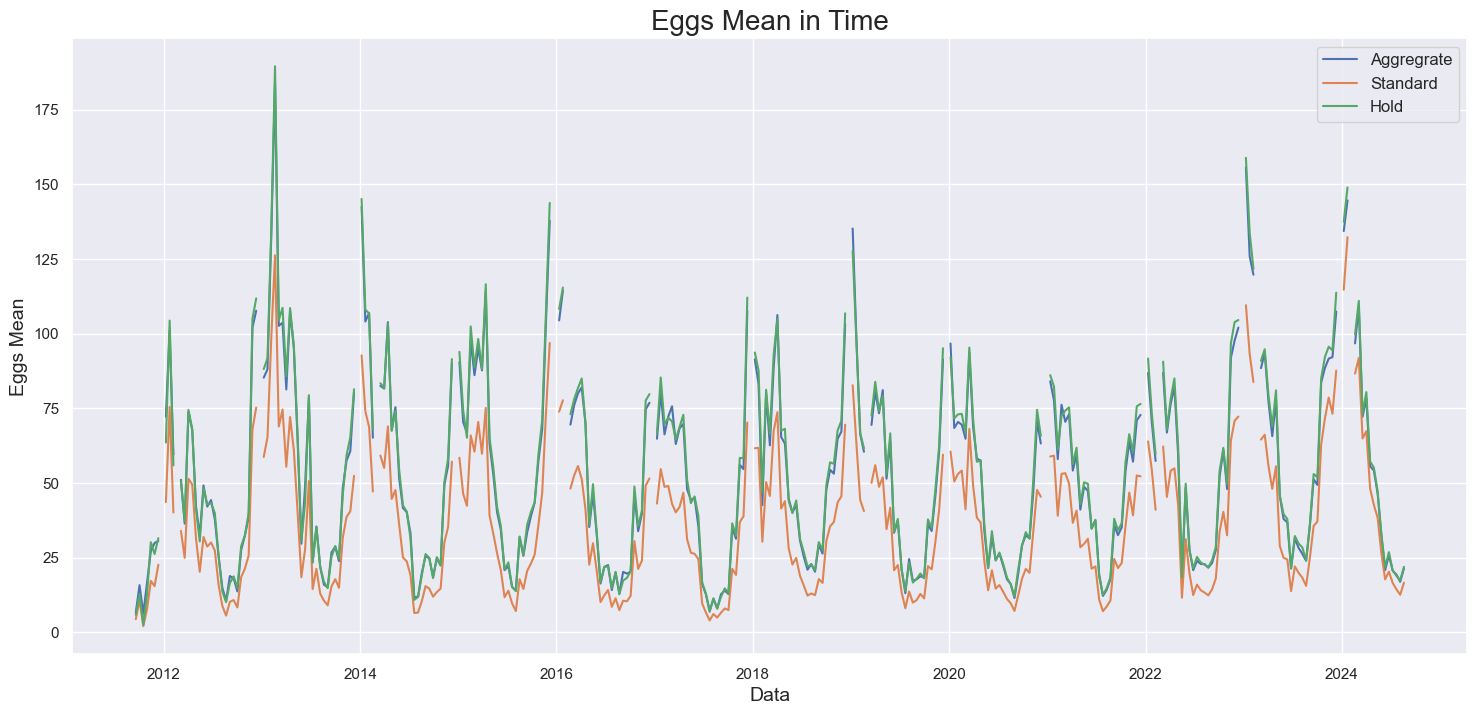

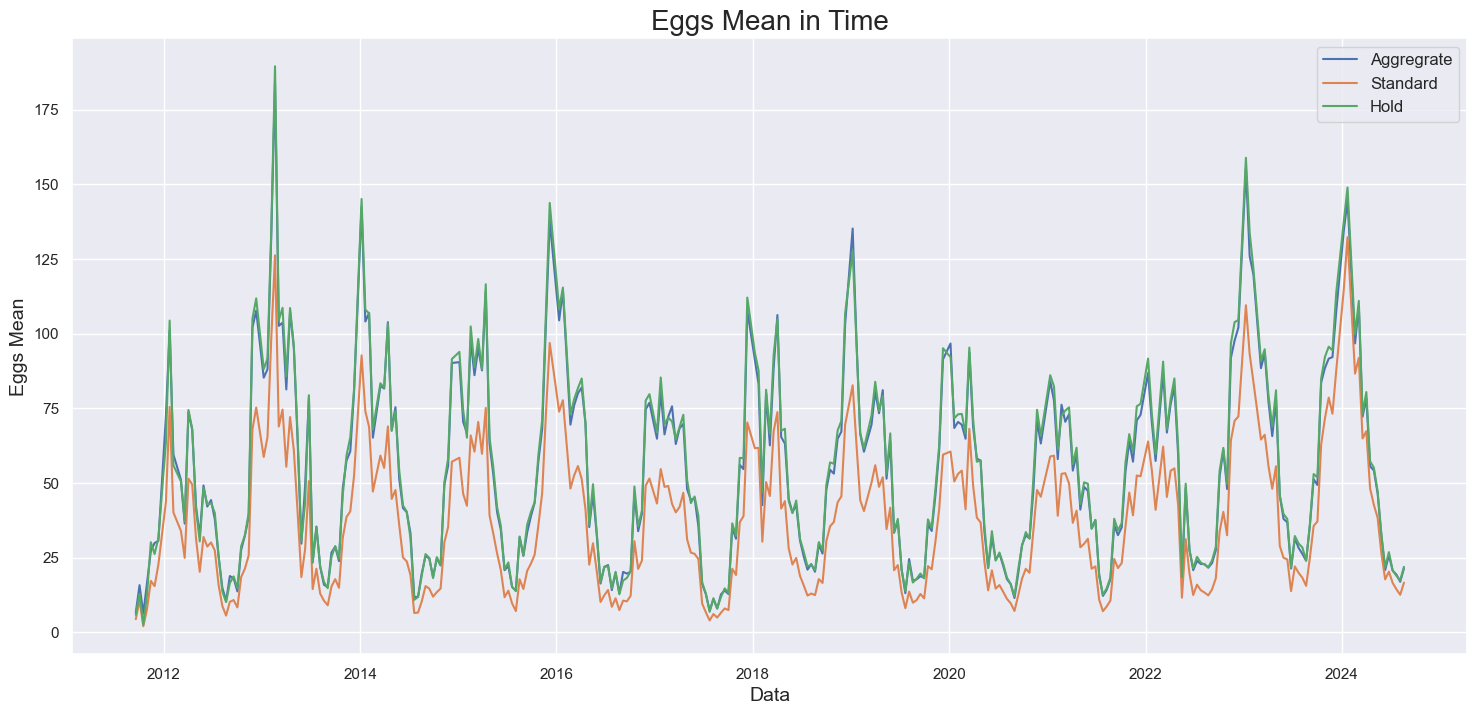

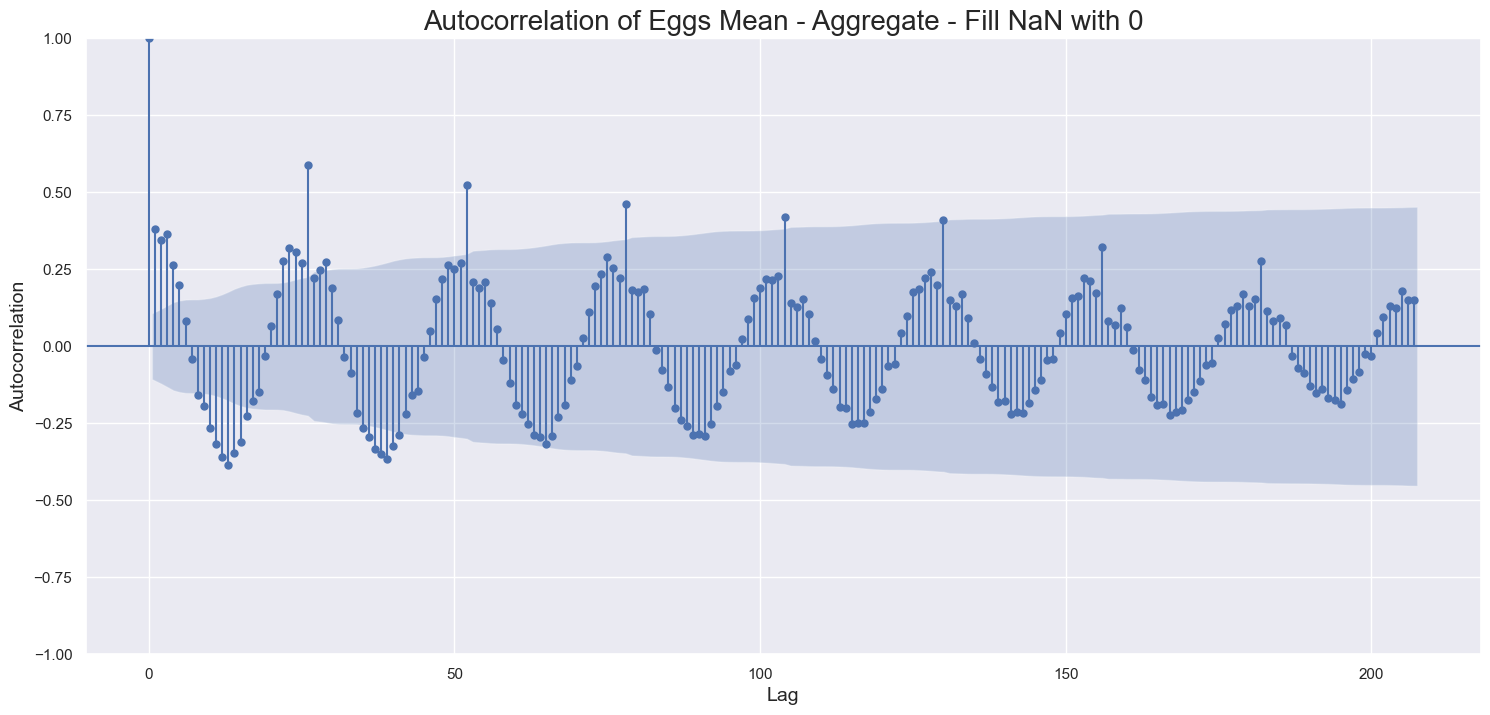

In [26]:
# Plot with NaN values
plt.plot(final_index,ovitraps_series_agg.values,label="Aggregrate")
plt.plot(final_index,ovitraps_series.values,label="Standard")   
plt.plot(final_index,ovitraps_series_hold.values,label="Hold")
plt.title("Eggs Mean in Time", fontsize=20)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Eggs Mean", fontsize=14)
plt.legend(fontsize=12)
plt.show()




# Plot without NaN values

sns.lineplot(x=final_index, y=ovitraps_series_agg, label="Aggregrate")
sns.lineplot(x=final_index, y=ovitraps_series, label="Standard")
sns.lineplot(x=final_index, y=ovitraps_series_hold, label="Hold")
plt.title("Eggs Mean in Time", fontsize=20)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Eggs Mean", fontsize=14)
plt.legend(fontsize=12)
plt.show()


# Correlation plot

plot_acf(ovitraps_series_agg.fillna(0), lags=207)

plt.title("Autocorrelation of Eggs Mean - Aggregate - Fill NaN with 0", fontsize=20)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)

plt.show()

# 8.0. Training Models

Considers the aggregated data and it's evaluated on the centroids. 80% of the dataset with the centroid is randomly aggregated into NUMBER_OF_SERIES=10 time series, each are used to train and test the model. Each model is trained NUMBER_OF_SERIES=10 times, one for each random series. It's important to note that the training and testing data ARE THE SAME for all the models.

The remaining 20% of the dataset is not used.

## 8.1. Create Data to Train and Test

In [34]:
training_matrix = ovitraps_matrix_agg[: int(ovitraps_matrix_agg.shape[0] * 0.8)].T
training_matrix

array([[5.5859375e+00, 4.0625000e+00,           nan, ..., 4.8093750e+01,
                  nan, 7.6000000e+01],
       [2.3691406e+00, 1.7519531e+00, 8.2812500e+00, ..., 4.9687500e+01,
                  nan, 1.2337500e+02],
       [1.6015625e+00, 2.7988281e+00, 8.2578125e+00, ..., 5.0750000e+01,
                  nan, 1.2787500e+02],
       ...,
       [1.9311523e-01, 3.3945312e+00,           nan, ..., 8.5687500e+01,
                  nan, 6.3468750e+01],
       [1.6640625e+01, 9.6777344e-01,           nan, ..., 1.2600000e+02,
                  nan, 2.9575000e+02],
       [1.6750000e+01, 9.7412109e-01,           nan, ..., 6.6062500e+01,
                  nan, 1.2925000e+02]], dtype=float32)

### 8.1.1. Creating Random Series

In [35]:
pd.DataFrame(training_matrix)

,0,1,2,3,4,5,6,...,262,263,264,265,266,267,268
0,5.585938,4.062500,NaN,1.822266,15.023438,14.531250,22.453125,...,133.6250,66.93750,40.09375,207.12500,48.09375,NaN,76.00000
1,2.369141,1.751953,8.281250,8.632812,18.515625,7.308594,42.625000,...,128.5000,65.12500,70.75000,129.75000,49.68750,NaN,123.37500
2,1.601562,2.798828,8.257812,10.546875,15.351562,29.375000,67.937500,...,108.9375,48.46875,85.56250,98.37500,50.75000,NaN,127.87500
3,18.937500,13.710938,NaN,4.957031,1.270508,50.312500,146.625000,...,88.8750,60.09375,67.18750,155.50000,56.71875,NaN,79.43750
4,8.484375,13.148438,NaN,NaN,4.277344,9.007812,NaN,...,55.3125,64.93750,76.75000,90.31250,84.62500,NaN,95.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.6250,58.00000,60.31250,141.75000,55.25000,NaN,50.65625
187,9.773438,5.796875,NaN,NaN,39.437500,23.203125,2.437500,...,55.2500,79.25000,66.68750,91.37500,102.50000,NaN,95.37500
188,0.193115,3.394531,NaN,16.328125,9.195312,24.218750,11.343750,...,44.9375,39.53125,63.28125,57.90625,85.68750,NaN,63.46875
189,16.640625,0.967773,NaN,NaN,52.968750,24.093750,NaN,...,25.8750,111.50000,89.87500,83.93750,126.00000,NaN,295.75000


In [36]:
NUMBER_OF_SERIES = 10
NUMBER_OF_POINTS = 40
WEEK_SHIFT       = 5
NUM_EPOCHS       = 20
error_dataframe = pd.DataFrame()

random_dataframe = pd.DataFrame()

for i in range(NUMBER_OF_SERIES):
  random_series = pd.DataFrame(create_random_series(pd.DataFrame(training_matrix), NUMBER_OF_POINTS), index = final_index[:training_matrix.shape[1]])
  random_dataframe = pd.concat([random_dataframe, random_series], axis=1, ignore_index=True)

random_dataframe

,0,1,2,3,4,5,6,7,8,9
2011-09-19,7.815651,8.224833,6.352857,6.329327,7.343316,9.319239,5.983459,5.288278,6.541767,5.656916
2011-10-03,11.887110,11.535970,14.196010,21.722656,14.573242,16.060171,15.408483,10.660319,12.878955,16.504297
2011-10-17,4.801697,3.867432,10.316406,4.667074,4.877523,4.485449,5.707868,18.796875,6.358538,2.682094
2011-10-31,10.966268,13.437337,18.856241,13.398046,13.796143,16.190012,11.325928,11.954443,10.049479,11.417411
2011-11-14,27.877481,19.936663,28.734934,30.043945,23.410904,33.589409,26.485424,24.778759,31.382353,30.956055
...,...,...,...,...,...,...,...,...,...,...
2021-11-15,61.930290,56.488899,57.665627,54.885818,54.156662,58.667068,57.697781,60.502533,59.726151,57.121483
2021-11-29,76.298080,71.155144,63.910545,70.312500,69.679276,68.455528,70.934212,76.863174,67.395973,73.999733
2021-12-13,69.375801,74.196793,67.236717,72.690308,68.558388,75.420670,76.733551,77.785477,74.169411,71.707535
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 8.2. MLP (Multilayer Perceptron)

### 8.2.1. Model 1

In [30]:
mlp_args_1 = {'model_shape':[8,16,1], 'model_name':"mlp_model_1"}
mlp_model_1, result_mlp_1, y_test_mlp1, X_test_mlp1, y_pred_mlp1 = train_model(random_dataframe, create_mlp_model, model_function_args = mlp_args_1,NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F298F02020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


### 8.2.2. Model 2

In [31]:
mlp_args_2 = {'model_shape':[8,32,1], 'model_name':"mlp_model_2"}
mlp_model_2, result_mlp_2, y_test_mlp2, X_test_mlp2, y_pred_mlp2 = train_model(random_dataframe, create_mlp_model, model_function_args = mlp_args_2, NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


## 8.3. LSTM (Long-Short Therm Memory)

### 8.3.1. LSTM 1

In [32]:
lstm_args_1 = {'model_shape':[32,1], 'model_name':"lstm_model_1"}
lstm_model_1, result_lstm_1,  y_test_lstm1, X_test_lstm1, y_pred_lstm1 = train_model(random_dataframe, create_lstm_model, model_function_args = lstm_args_1, NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


### 8.3.2. Model 2

In [33]:
lstm_args_2 = {'model_shape':[128,1], 'model_name':"lstm_model_2"}
lstm_model_2,result_lstm_2,  y_test_lstm2, X_test_lstm2, y_pred_lstm2 = train_model(random_dataframe, create_lstm_model, model_function_args = lstm_args_2, NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


### 8.3.3. Model 3

In [34]:
lstm_args_3 = {'model_shape':[128,128,1], 'model_name':"lstm_model_3"}
lstm_model_3,result_lstm_3, y_test_lstm3, X_test_lstm3, y_pred_lstm3 = train_model(random_dataframe, create_lstm_model, model_function_args = lstm_args_3, NUM_EPOCHS=NUM_EPOCHS)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


## 8.4. GRU (Gated Recurrent Unity)

### 8.4.1. Model 1

In [35]:
gru_args_1 = {'model_shape':[32,1], 'model_name':"gru_model_1"}
gru_model_1, result_gru_1, y_test_gru1, X_test_gru1, y_pred_gru1 = train_model(random_dataframe, create_gru_model, model_function_args = gru_args_1, NUM_EPOCHS=NUM_EPOCHS)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


### 8.4.2. Model 2

In [36]:
gru_args_2 = {'model_shape':[128,1], 'model_name':"gru_model_2"}
gru_model_2, result_gru_2, y_test_gru2, X_test_gru2, y_pred_gru2 = train_model(random_dataframe, create_gru_model, model_function_args = gru_args_2, NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


### 8.4.3. Model 3

In [37]:
gru_args_3 = {'model_shape':[128,128,1], 'model_name':"gru_model_3"}
gru_model_3, result_gru_3, y_test_gru3, X_test_gru3, y_pred_gru3 = train_model(random_dataframe, create_gru_model, model_function_args = gru_args_3, NUM_EPOCHS=NUM_EPOCHS)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


## 8.5. SARIMA

In [38]:
_,_,_,_,_ = train_sarima_model(random_dataframe, save_results=True, order=(4, 0, 4), seasonal_order=(4, 0, 4, 26))

## Add Naive

In [39]:
_,_,_,_,_ = train_complex_naive(random_dataframe, save_results=True)

# 9.0. Models Errors

In [41]:
error_dataframe.to_csv(f"../results/cbic_2023/models/error_dataframe_epochs_{NUM_EPOCHS}.csv")
mae_columns  = [column for column in error_dataframe.columns if "MAE" in column]
rmse_columns = [column for column in error_dataframe.columns if "RMSE" in column]

mae_mean_error  = error_dataframe[mae_columns].T.mean()
rmse_mean_error = error_dataframe[rmse_columns].T.mean()

mean_error_dataframe = pd.DataFrame({
  "MAE": mae_mean_error,
  "RMSE": rmse_mean_error
}, index = mae_mean_error.index)

mean_error_dataframe

,MAE,RMSE
mlp_model_1,39.164321,43.803078
mlp_model_2,37.489821,42.306800
lstm_model_1,11.653067,14.030768
lstm_model_2,9.596643,11.860296
lstm_model_3,9.454091,11.917637
gru_model_1,11.140679,14.221260
gru_model_2,9.678803,11.539645
gru_model_3,9.643428,11.502411
SARIMA,9.167150,11.492346
Naive,9.440285,11.894600


Sort by error

In [42]:
mean_error_dataframe.sort_values("MAE")      

,MAE,RMSE
SARIMA,9.167150,11.492346
Naive,9.440285,11.894600
lstm_model_3,9.454091,11.917637
lstm_model_2,9.596643,11.860296
gru_model_3,9.643428,11.502411
gru_model_2,9.678803,11.539645
gru_model_1,11.140679,14.221260
lstm_model_1,11.653067,14.030768
mlp_model_2,37.489821,42.306800
mlp_model_1,39.164321,43.803078


In [43]:
mean_error_dataframe.sort_values("RMSE")

,MAE,RMSE
SARIMA,9.167150,11.492346
gru_model_3,9.643428,11.502411
gru_model_2,9.678803,11.539645
lstm_model_2,9.596643,11.860296
Naive,9.440285,11.894600
lstm_model_3,9.454091,11.917637
lstm_model_1,11.653067,14.030768
gru_model_1,11.140679,14.221260
mlp_model_2,37.489821,42.306800
mlp_model_1,39.164321,43.803078


# 10.0. Selecting best models

Given the previous results, the best models for each type is select. The mean of all the aggregated centroids is used to train and test the models (80/20). As before, the training and testing data are the same for all the models but only one model is trained for each type. 

In [44]:
# deterministic split
input, target = create_dataset(ovitraps_series_agg, WEEK_SHIFT)
X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

# Create boolean index arrays for each set
all_index = [i in target for i in ovitraps_series_agg ] 
test_index = [i in y_test for i in ovitraps_series_agg] 
train_index = [i in y_train for i in ovitraps_series_agg] 

# Train Naive model
(X_train_naive_best, X_test_naive_best, y_train_naive_best,
  y_test_naive_best, y_pred_naive_best) = train_complex_naive(pd.DataFrame(ovitraps_series_agg),
                                                              save_results=False)
naive_to_plot = np.append(X_train_naive_best[:,-1],y_pred_naive_best)
mae_naive, rmse_naive = mean_absolute_error(y_test_naive_best, y_pred_naive_best),  np.sqrt(mean_squared_error(y_test, y_pred_naive_best))

## 10.1 Aggregated Series

### 10.1.1. MLP

In [45]:
# Train model
mlp_args_best = {'model_shape':[8,32,1], 'model_name':"mlp_model_2"}

(mlp_model_best,
 result_mlp_best,
 y_test_mlpbest, 
 X_test_mlpbest,
 y_pred_mlpbest) = train_model(pd.DataFrame(ovitraps_series_agg),
                              create_lstm_model,
                              model_function_args = mlp_args_best,
                              NUM_EPOCHS=NUM_EPOCHS,
                              best_model=1)

# Predict for all data
y_pred = []
for value in input:
  value = np.array(value)
  y_pred.append(result_mlp_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
# Create a DataFrame for the predictions
pred_series_by_mlp = pd.DataFrame(y_pred, index=ovitraps_series_agg.index[all_index])

# Predict for test data
y_pred_test_mlp = []
for value in X_test_mlpbest:
  value = np.array(value)
  y_pred_test_mlp.append(result_mlp_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
y_pred_test_series_by_mlp = pd.DataFrame(y_pred_test_mlp, index=ovitraps_series_agg[-len(X_test_mlpbest):].index)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


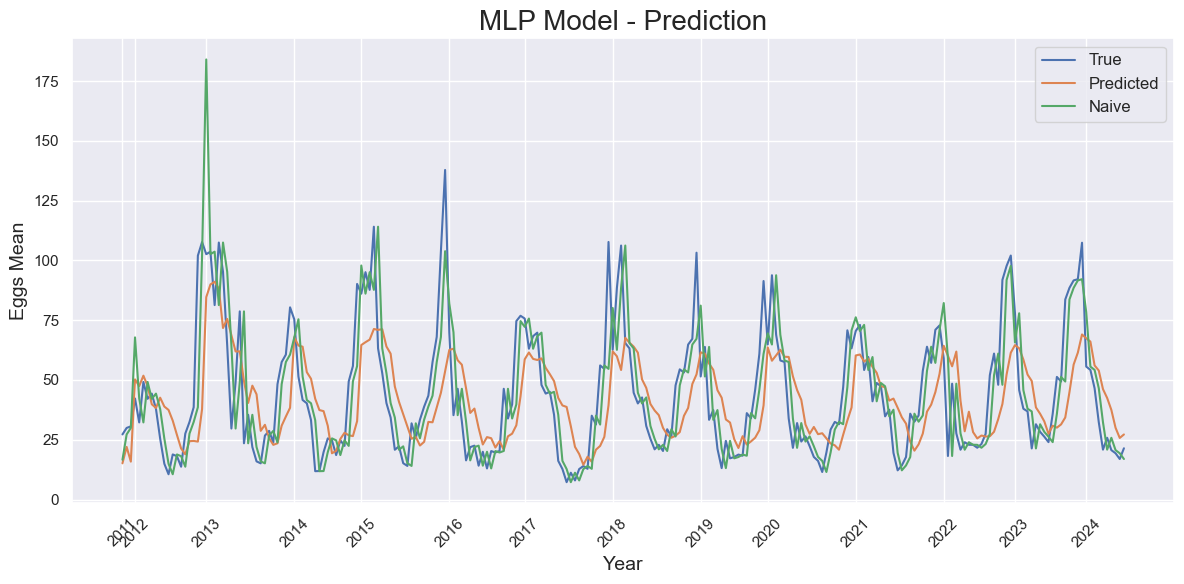

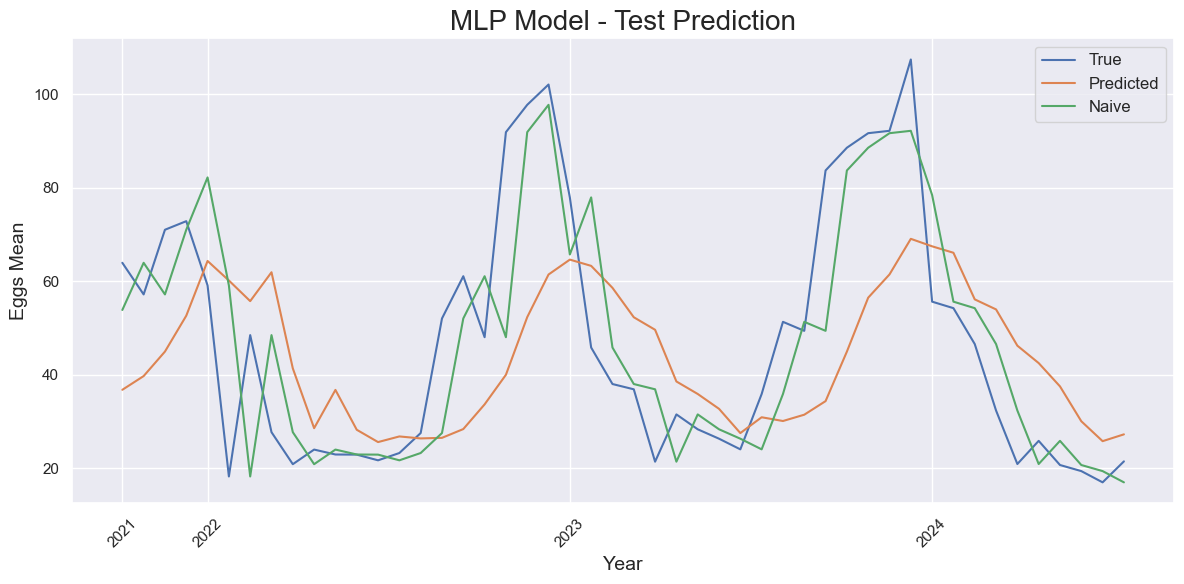

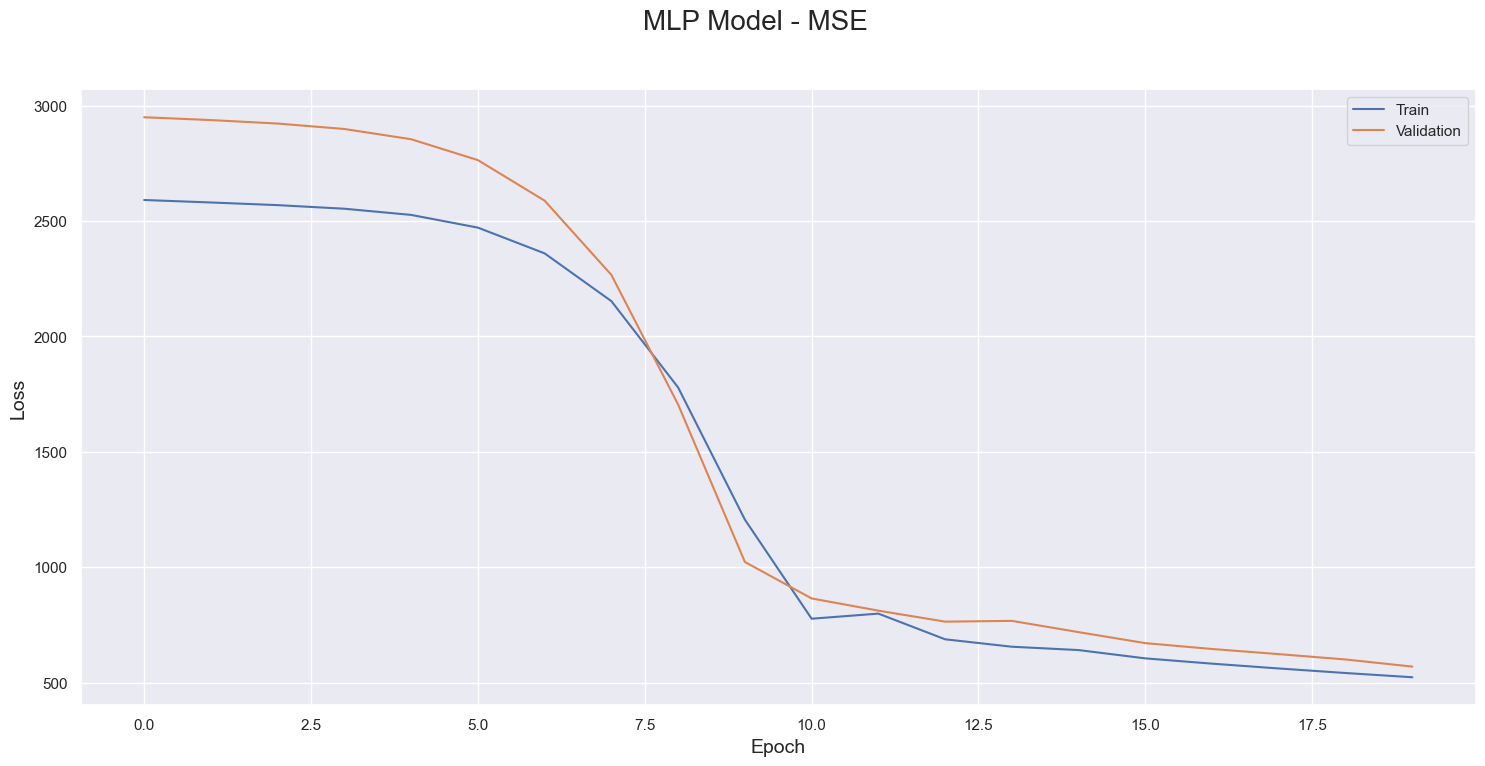

In [46]:
results_plot(ovitraps_series_agg[all_index].values, pred_series_by_mlp.values, naive_to_plot, ovitraps_series_agg.index[all_index], "MLP Model - Prediction")
results_plot(y_test_mlpbest, y_pred_test_series_by_mlp.values, y_pred_naive_best,ovitraps_series_agg.index[test_index], "MLP Model - Test Prediction")
plot_loss(result_mlp_best, "MLP Model - MSE")


### 10.1.2. LSTM

In [47]:
# Create LSTM model
lstm_args_best = {'model_shape':[32,1], 'model_name':"lstm_model_best1"}
lstm_model_best,result_lstm_best, y_test_lstmbest, X_test_lstmbest, y_pred_lstmbest = train_model(pd.DataFrame(ovitraps_series_agg), create_lstm_model, model_function_args = lstm_args_best, NUM_EPOCHS=NUM_EPOCHS, best_model=1)

# Predict for all data
y_pred = []
for value in input:
  value = np.array(value)
  y_pred.append(result_lstm_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
pred_series_by_lstm = pd.DataFrame(y_pred, index=ovitraps_series_agg.index[all_index])

# Predict for test data
y_pred_test_lstm = []
for value in X_test_lstmbest:
  value = np.array(value)
  y_pred_test_lstm.append(result_lstm_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
y_pred_test_series_by_lstm = pd.DataFrame(y_pred_test_lstm, index=ovitraps_series_agg[-len(X_test_lstmbest):].index)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


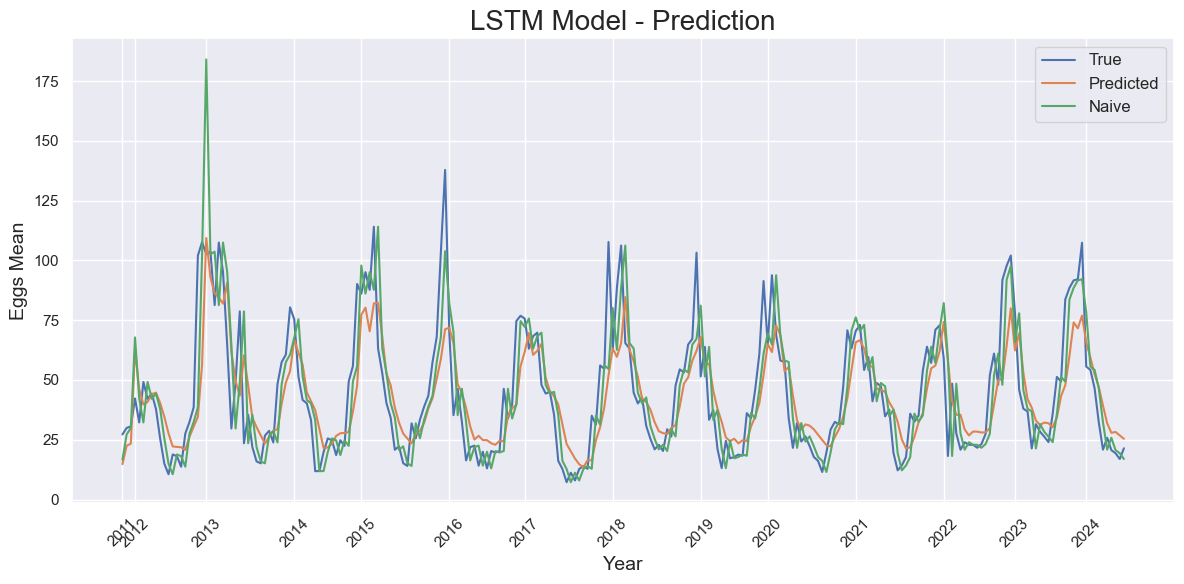

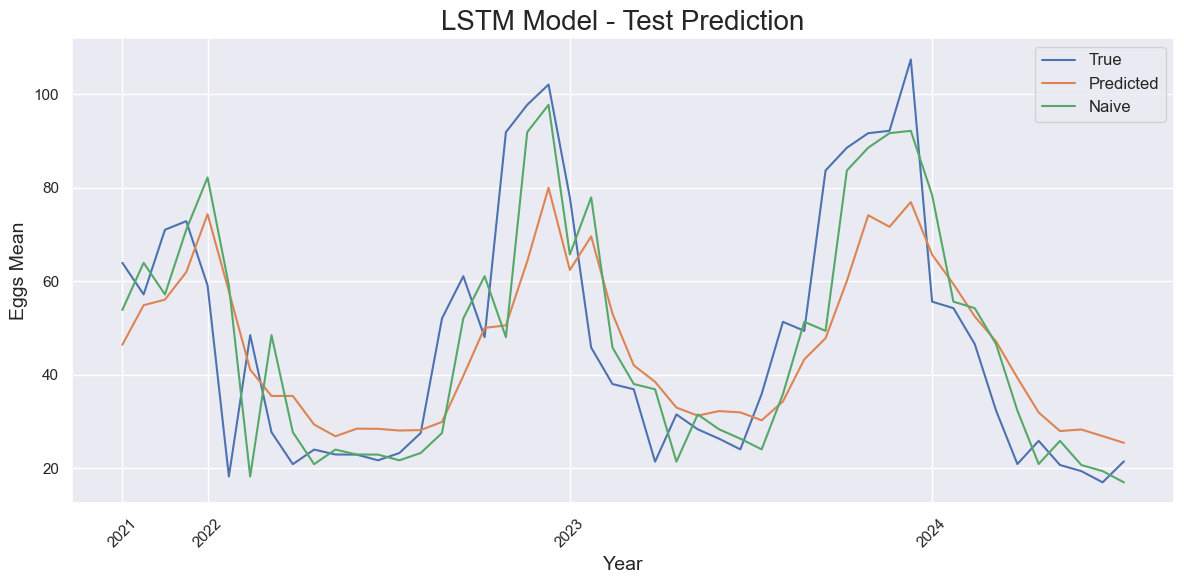

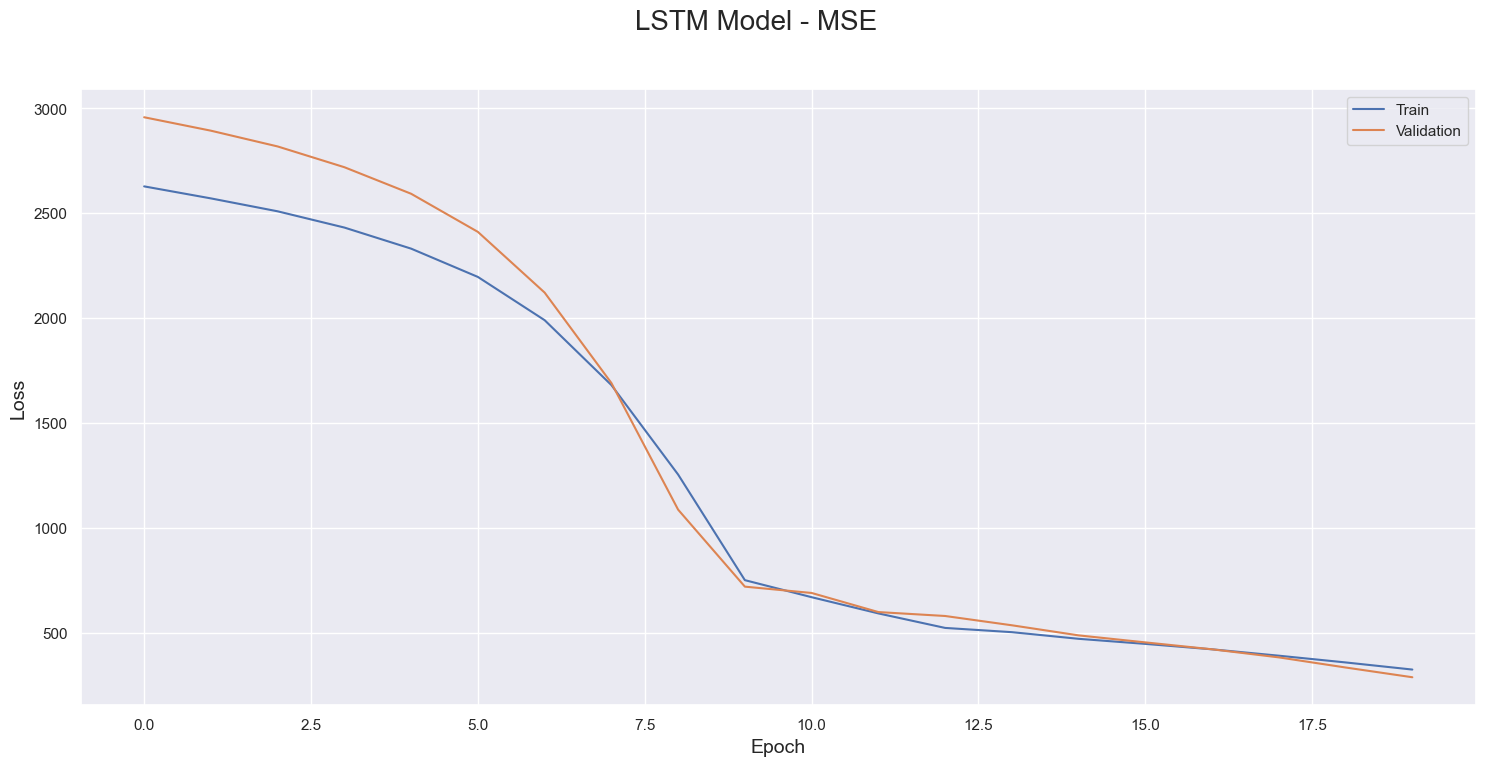

In [48]:
results_plot(ovitraps_series_agg[all_index].values, pred_series_by_lstm.values,naive_to_plot, ovitraps_series_agg.index[all_index] , "LSTM Model - Prediction")
results_plot(y_test_lstmbest, y_pred_test_series_by_lstm.values, y_pred_naive_best, ovitraps_series_agg.index[test_index], "LSTM Model - Test Prediction")
plot_loss(result_lstm_best, "LSTM Model - MSE")

### 10.1.3. GRU

In [49]:
# Create model
gru_args_best = {'model_shape':[32,1], 'model_name':"gru_model_best1"}
gru_model_best,result_gru_best, y_test_grubest, X_test_grubest, y_pred_grubest = train_model(pd.DataFrame(ovitraps_series_agg), create_gru_model, model_function_args = gru_args_best, NUM_EPOCHS=NUM_EPOCHS, best_model=1)

# Predict for all data
y_pred = []
for value in input:
  value = np.array(value)
  y_pred.append(result_gru_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
pred_series_by_gru = pd.DataFrame(y_pred, index=ovitraps_series_agg.index[all_index])

# Predict for test data
y_pred_test_gru = []
for value in X_test_grubest:
  value = np.array(value)
  y_pred_test_gru.append(result_gru_best.model.predict(value.reshape(1, 4),verbose=0)[0][0])
y_pred_test_series_by_gru = pd.DataFrame(y_pred_test_gru, index=ovitraps_series_agg[-len(X_test_grubest):].index)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


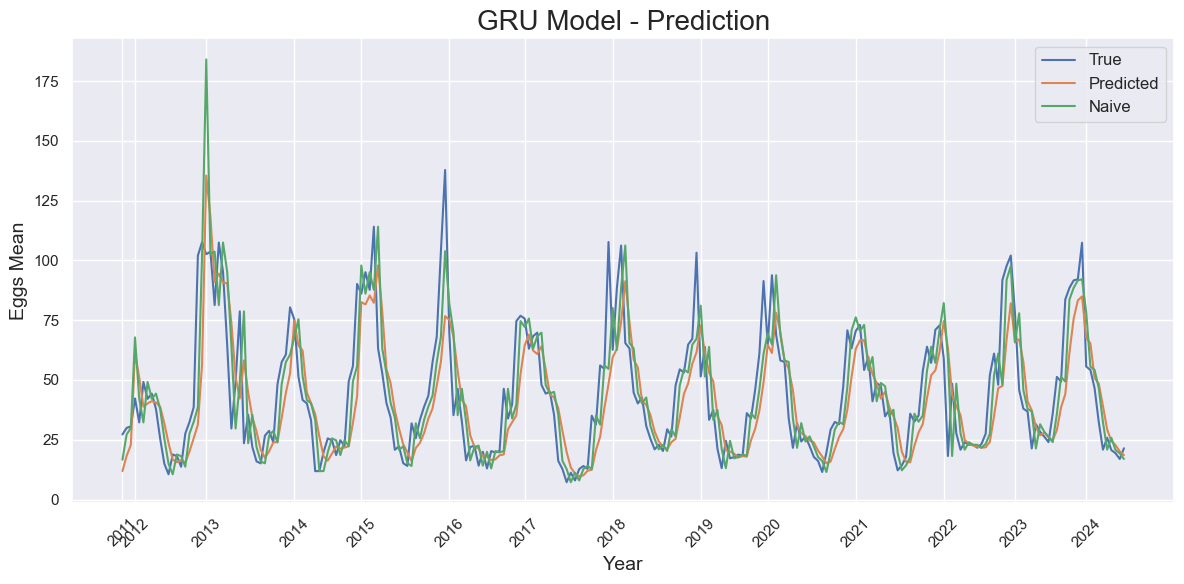

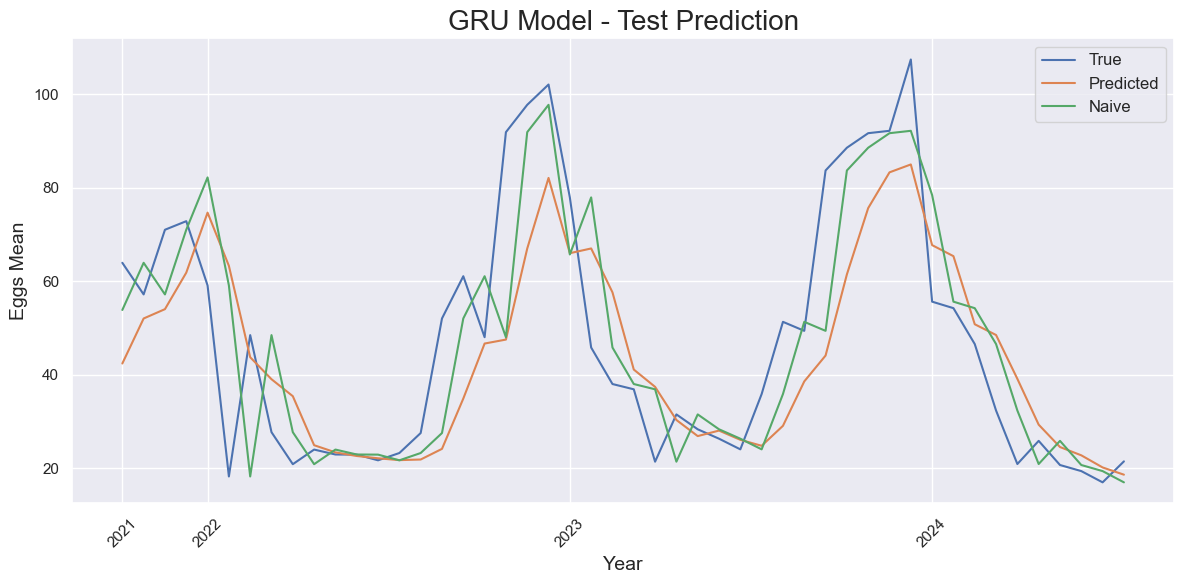

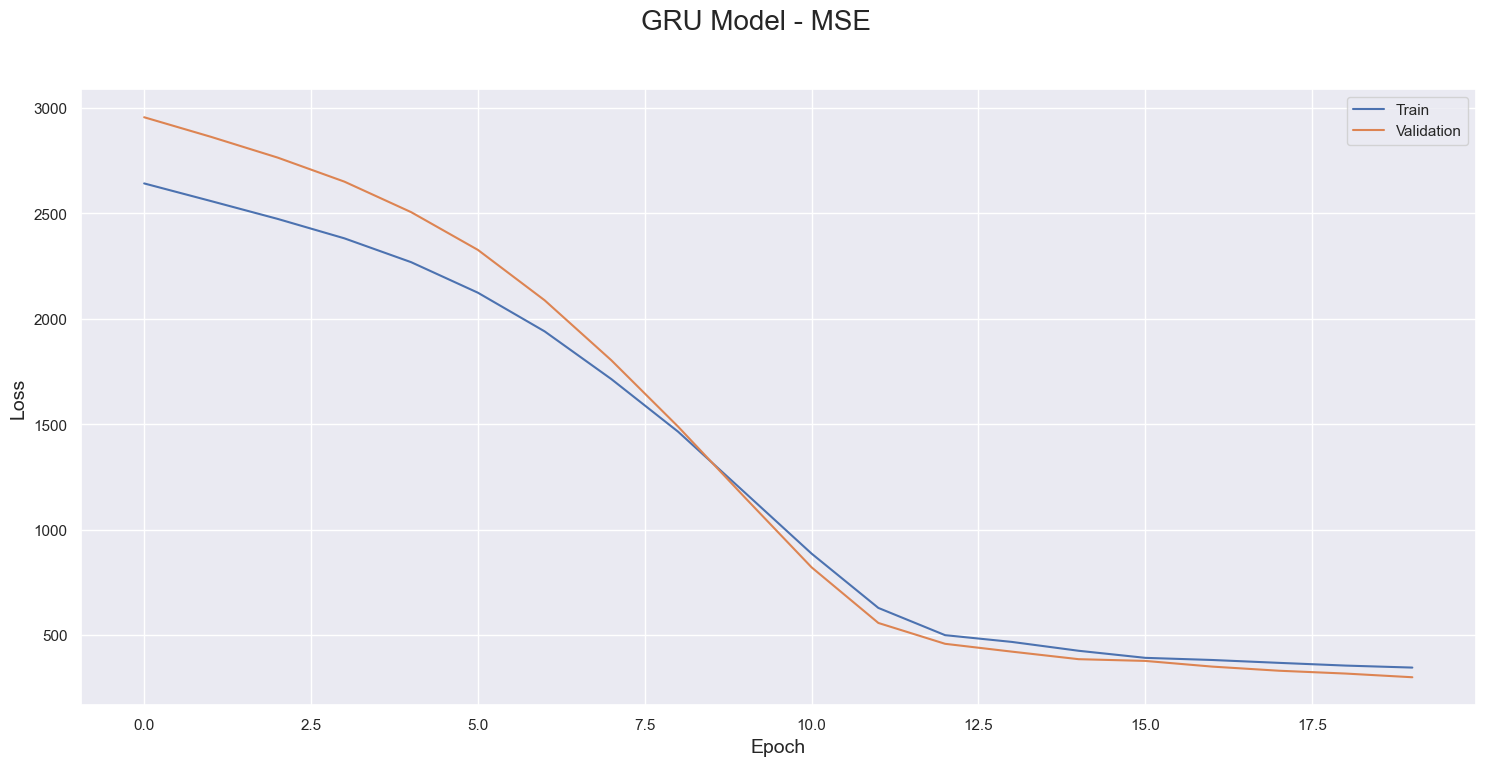

In [50]:
results_plot(ovitraps_series_agg[all_index].values, pred_series_by_gru.values,naive_to_plot,ovitraps_series_agg.index[all_index], "GRU Model - Prediction")
results_plot(y_test_grubest, y_pred_test_series_by_gru.values,y_pred_naive_best,ovitraps_series_agg.index[test_index], "GRU Model - Test Prediction")
plot_loss(result_gru_best, "GRU Model - MSE")


### 10.1.4. SARIMA


In [51]:
# Create model
(X_train_sarima_best, X_test_sarima_best, y_train_sarima_best,
  y_test_sarima_best, y_pred_sarima_best) = train_sarima_model(pd.DataFrame(ovitraps_series_agg),
                                                            save_results=True,
                                                            order=(4, 0, 4),
                                                            seasonal_order=(4, 0, 4, 26))
# Predict for all data
pred_series_by_sarima = pd.DataFrame(y_pred_sarima_best, index=ovitraps_series_agg.index[test_index])



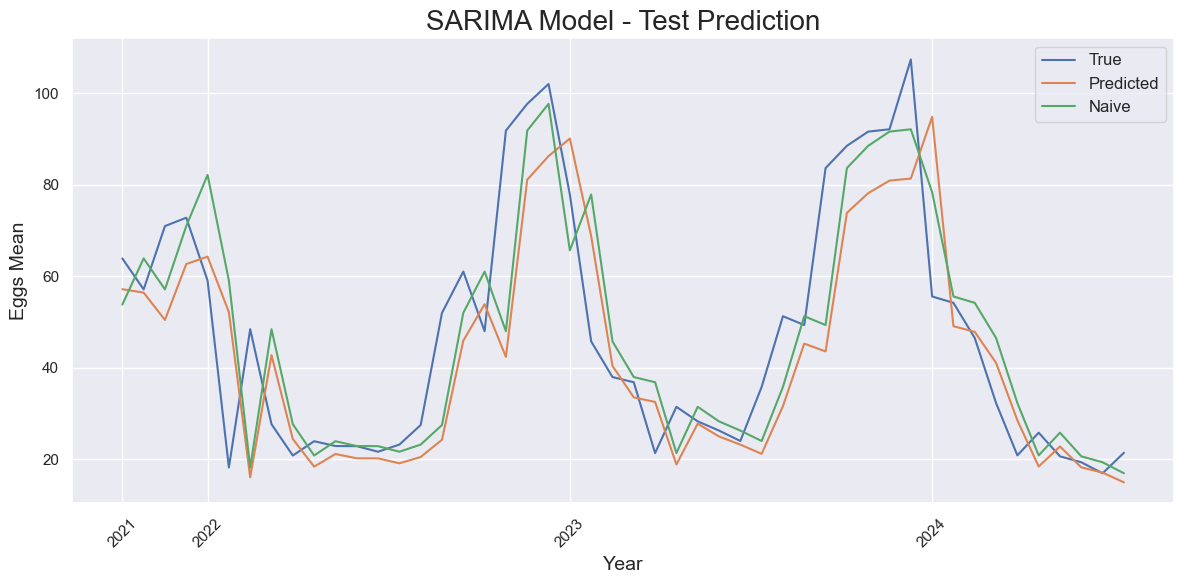

In [52]:
results_plot(y_test_sarima_best, y_pred_sarima_best,y_pred_naive_best,ovitraps_series_agg.index[test_index], "SARIMA Model - Test Prediction")


### 10.1.6 FINAL METRICS

In [53]:
mae_mlp = mean_absolute_error(y_test, y_pred_test_series_by_mlp.values)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_series_by_mlp.values))
mae_lstm = mean_absolute_error(y_test, y_pred_test_series_by_lstm.values)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_series_by_lstm.values))
mae_gru = mean_absolute_error(y_test, y_pred_test_series_by_gru.values)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_test_series_by_gru.values))

mae_sarima = mean_absolute_error(y_test, y_pred_sarima_best)
rmse_sarima = np.sqrt(mean_squared_error(y_test, y_pred_sarima_best))


metrics_df = pd.DataFrame({
    "MAE": [mae_mlp, mae_lstm, mae_gru, mae_naive, mae_sarima],
    "RMSE": [rmse_mlp, rmse_lstm, rmse_gru, rmse_naive,rmse_sarima]
}, index=["MLP", "LSTM", "GRU", "Naive","SARIMA"])

metrics_df.to_csv(f"../results/cbic_2023/error/best_model_error_{NUM_EPOCHS}_epochs.csv")

metrics_df

,MAE,RMSE
MLP,19.639475,23.857012
LSTM,13.469602,16.940912
GRU,12.956703,17.336000
Naive,10.744102,15.292530
SARIMA,11.916501,16.685126


In [54]:
metrics_df

,MAE,RMSE
MLP,19.639475,23.857012
LSTM,13.469602,16.940912
GRU,12.956703,17.336000
Naive,10.744102,15.292530
SARIMA,11.916501,16.685126


## 10.2. For Each Ovitrap Aggregated Point

Use the previous models to predict the result for each centroid

In [55]:
data_to_predict = pd.DataFrame(ovitraps_matrix_agg).iloc[int(ovitraps_matrix_agg.shape[0] * 0.8):]
pred_matrix_by_lstm = []
pred_matrix_by_gru  = []
pred_matrix_by_mlp = []
pred_matrix_naive = []
ytest = []

for idx_i, col in enumerate(data_to_predict.columns):
  pred_lstm = []
  pred_gru  = []
  pred_mlp  = []
  pred_naive = []

  input_row, target = create_dataset(data_to_predict[col], WEEK_SHIFT)

  for idx_j, input in enumerate(input_row):
    input = np.array(input)
    input = input.reshape(1, 4)

    pred_lstm.append(lstm_model_best.predict(input,verbose=0)[0][0])
    pred_gru.append(gru_model_best.predict(input,verbose=0)[0][0])
    pred_mlp.append(mlp_model_best.predict(input,verbose=0)[0][0])
    pred_naive.append(input[0][-1])  # Naive prediction is the last value in the input

  pred_matrix_by_lstm.append(pred_lstm)
  pred_matrix_by_gru.append(pred_gru)
  pred_matrix_by_mlp.append(pred_mlp)
  pred_matrix_naive.append(pred_naive)
  ytest.append(target)



In [56]:
lstm_big_list = [y for sublist in pred_matrix_by_lstm for y in sublist]
gru_big_list = [y for sublist in pred_matrix_by_gru for y in sublist]
mlp_big_list = [y for sublist in pred_matrix_by_mlp for y in sublist]
naive_big_list = [y for sublist in pred_matrix_naive for y in sublist]
ytest_big_list = [y for sublist in ytest for y in sublist]



### Error for centroids

In [57]:
error_centroid = pd.DataFrame(columns=["MAE", "RMSE"], index=["mlp", "lstm", "gru", "naive"])

error_centroid.loc['lstm']['MAE'] = mean_absolute_error(lstm_big_list,ytest_big_list)
error_centroid.loc['lstm']['RMSE'] = np.sqrt(mean_squared_error(lstm_big_list, ytest_big_list))
error_centroid.loc['gru']['MAE'] = mean_absolute_error(gru_big_list, ytest_big_list)
error_centroid.loc['gru']['RMSE'] = np.sqrt(mean_squared_error(gru_big_list, ytest_big_list))
error_centroid.loc['mlp']['MAE'] = mean_absolute_error(mlp_big_list, ytest_big_list)
error_centroid.loc['mlp']['RMSE'] = np.sqrt(mean_squared_error(mlp_big_list, ytest_big_list))
error_centroid.loc['naive']['MAE'] = mean_absolute_error(naive_big_list, ytest_big_list)
error_centroid.loc['naive']['RMSE'] = np.sqrt(mean_squared_error(naive_big_list, ytest_big_list))


error_centroid.to_csv(f"../results/cbic_2023/error/error_centroid_{NUM_EPOCHS}_epochs.csv")
error_centroid


,MAE,RMSE
mlp,24.356932,33.027454
lstm,20.269016,28.466009
gru,20.326946,28.555595
naive,21.774006,30.191776


## 10.3 Train and test on Centroids

In [58]:
# Create test and train matrices for the final model, making the centroids alligned
nan_row = np.full((1, ovitraps_matrix_agg.shape[1]), np.nan)

train_matrix_end = ovitraps_matrix_agg[:int(0.8*ovitraps_matrix_agg.shape[0]), :]
train_matrix_end = np.vstack([train_matrix_end, nan_row])
train_matrix_end = train_matrix_end.flatten()
    
test_matrix_end = ovitraps_matrix_agg[int(0.8*ovitraps_matrix_agg.shape[0])-4:, :]
test_matrix_end = np.vstack([test_matrix_end,nan_row])
test_matrix_end = test_matrix_end.flatten()

random_matrix_agg = np.hstack([train_matrix_end, test_matrix_end])
random_dataframe_agg = pd.DataFrame(random_matrix_agg)

train_size = len(train_matrix_end) / len(random_matrix_agg) 


In [59]:
error_dataframe = pd.DataFrame()
(mlp_model_agg, result_mlp_agg, y_test_mlp_agg,
  X_test_mlp_agg, y_pred_mlp_agg) = train_model(random_dataframe_agg, create_mlp_model,
                                                 model_function_args = mlp_args_2,NUM_EPOCHS=NUM_EPOCHS, train_size=train_size)

(lstm_model_agg, result_lstm_agg,  y_test_lstm_agg,
  X_test_lstm_agg, y_pred_lstm_agg) = train_model(random_dataframe_agg, create_lstm_model,
                                                   model_function_args = lstm_args_1, NUM_EPOCHS=NUM_EPOCHS, train_size=train_size)

(gru_model_agg, result_gru_agg, y_test_gru_agg,
  X_test_gru_agg, y_pred_gru_agg) = train_model(random_dataframe_agg, create_gru_model,
                                                 model_function_args = gru_args_1, NUM_EPOCHS=NUM_EPOCHS, train_size=train_size)

train_complex_naive(random_dataframe_agg, save_results=True, train_size=train_size)



330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(array([[ 5.5859375 ,  2.36914062,  1.6015625 , 18.9375    ],
        [ 2.36914062,  1.6015625 , 18.9375    ,  8.484375  ],
        [ 1.6015625 , 18.9375    ,  8.484375  , 19.453125  ],
        ...,
        [63.03125   , 35.5       , 25.109375  , 57.96875   ],
        [35.5       , 25.109375  , 57.96875   , 62.6875    ],
        [25.109375  , 57.96875   , 62.6875    , 49.46875   ]]),
 array([[57.96875  , 62.6875   , 49.46875  , 69.375    ],
        [62.6875   , 49.46875  , 69.375    , 43.5625   ],
        [49.46875  , 69.375    , 43.5625   , 60.25     ],
        ...,
        [15.3359375, 27.46875  , 30.796875 , 22.890625 ],
        [27.46875  , 30.796875 , 22.890625 , 13.625    ],
        [30.796875 , 22.890625 , 13.625    , 20.890625 ]]),
 array([ 8.484375, 19.453125, 19.28125 , ..., 62.6875  , 49.46875 ,
        69.375   ]),
 array([43.5625  , 60.25    , 73.625   , ..., 13.625   , 20.890625,
        22.65625 ]),
 array([69.375   , 43.5625  , 60.25    , ..., 22.890625, 13.625   ,
    

In [61]:
error_dataframe.to_csv(f"../results/cbic_2023/models/error_dataframe_agg_epochs_{NUM_EPOCHS}.csv")
mae_columns  = [column for column in error_dataframe.columns if "MAE" in column]
rmse_columns = [column for column in error_dataframe.columns if "RMSE" in column]

mae_mean_error_agg  = error_dataframe[mae_columns].T.mean()
rmse_mean_error_agg = error_dataframe[rmse_columns].T.mean()

mean_error_dataframe_agg = pd.DataFrame({
  "MAE": mae_mean_error_agg,
  "RMSE": rmse_mean_error_agg
}, index = mae_mean_error_agg.index)

mean_error_dataframe_agg

,MAE,RMSE
mlp_model_2,20.884981,30.807462
lstm_model_1,20.844935,30.331554
gru_model_1,20.853400,30.335710
Naive,24.406096,35.713433


In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

sarima_model = SARIMAXResults.load("./models/SARIMA_(4, 0, 4)_(4, 0, 4, 26)_column_0.h5")

In [63]:
y_pred = []
for t in y_test:
    pred = sarima_model.forecast(steps=1)
    y_pred.append(pred[0])
    sarima_model = sarima_model.apply([t])

## 10.4 Train and test on real data

### 10.4.1 Without Median < 1

In [27]:
y_train_hold = ovitraps_series_hold[:int(0.8*ovitraps_series_hold.shape[0])]
y_test_hold  = ovitraps_series_hold[int(0.8*ovitraps_series_hold.shape[0]):]

In [39]:
error_dataframe = pd.DataFrame()
ovitraps_series_hold_df = pd.DataFrame(ovitraps_series_hold)

(mlp_model_agg, result_mlp_agg, y_test_mlp_agg,
  X_test_mlp_agg, y_pred_mlp_agg) = train_model(ovitraps_series_hold_df, create_mlp_model,
                                                 model_function_args = mlp_args_2,NUM_EPOCHS=NUM_EPOCHS)

(lstm_model_agg, result_lstm_agg,  y_test_lstm_agg,
  X_test_lstm_agg, y_pred_lstm_agg) = train_model(ovitraps_series_hold_df, create_lstm_model,
                                                   model_function_args = lstm_args_1, NUM_EPOCHS=NUM_EPOCHS)

(gru_model_agg, result_gru_agg, y_test_gru_agg,
  X_test_gru_agg, y_pred_gru_agg) = train_model(ovitraps_series_hold_df, create_gru_model,
                                                 model_function_args = gru_args_1, NUM_EPOCHS=NUM_EPOCHS)

_,_,_,_,_ = train_complex_naive(ovitraps_series_hold_df, save_results=True)
_,_,_,_,_  = train_sarima_model(ovitraps_series_hold_df, save_results=True, order=(4, 0, 4), seasonal_order=(4, 0, 4, 26))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


In [66]:
error_dataframe.to_csv(f"../results/cbic_2023/models/error_dataframe_hold_epochs_{NUM_EPOCHS}.csv")
mae_columns  = [column for column in error_dataframe.columns if "MAE" in column]
rmse_columns = [column for column in error_dataframe.columns if "RMSE" in column]

mae_mean_error_hold  = error_dataframe[mae_columns].T.mean()
rmse_mean_error_hold = error_dataframe[rmse_columns].T.mean()

mean_error_dataframe_hold = pd.DataFrame({
  "MAE": mae_mean_error_hold,
  "RMSE": rmse_mean_error_hold
}, index = mae_mean_error_hold.index)

mean_error_dataframe_hold

,MAE,RMSE
mlp_model_2,45.502444,53.295093
lstm_model_1,13.076733,16.443547
gru_model_1,13.679550,18.003367
Naive,11.123805,15.990723
SARIMA,11.901286,17.324601


### 10.4.2 With Median < 1

In [67]:
y_train_og = ovitraps_series[:int(0.8*ovitraps_series.shape[0])]
y_test_og  = ovitraps_series[int(0.8*ovitraps_series.shape[0]):]

In [37]:
error_dataframe = pd.DataFrame()
ovitraps_series_df = pd.DataFrame(ovitraps_series)


(mlp_model_og, result_mlp_og, y_test_mlp_og,
  X_test_mlp_og, y_pred_mlp_og) = train_model(ovitraps_series_df, create_mlp_model,
                                                 model_function_args = mlp_args_2,NUM_EPOCHS=NUM_EPOCHS)

(lstm_model_og, result_lstm_og,  y_test_lstm_og,
  X_test_lstm_og, y_pred_lstm_og) = train_model(ovitraps_series_df, create_lstm_model,
                                                   model_function_args = lstm_args_1, NUM_EPOCHS=NUM_EPOCHS)

(gru_model_og, result_gru_og, y_test_gru_og,
  X_test_gru_og, y_pred_gru_og) = train_model(ovitraps_series_df, create_gru_model,
                                                 model_function_args = gru_args_1, NUM_EPOCHS=NUM_EPOCHS)
_,_,_,_,_ = train_complex_naive(ovitraps_series_df, save_results=True)
_,_,_,_,_  = train_sarima_model(ovitraps_series_df, save_results=True, order=(4, 0, 4), seasonal_order=(4, 0, 4, 26))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026E3D78C180> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [38]:
error_dataframe.to_csv(f"../results/cbic_2023/models/error_dataframe_og_epochs_{NUM_EPOCHS}.csv")
mae_columns  = [column for column in error_dataframe.columns if "MAE" in column]
rmse_columns = [column for column in error_dataframe.columns if "RMSE" in column]

mae_mean_error_og  = error_dataframe[mae_columns].T.mean()
rmse_mean_error_og = error_dataframe[rmse_columns].T.mean()

mean_error_dataframe_og = pd.DataFrame({
  "MAE": mae_mean_error_og,
  "RMSE": rmse_mean_error_og
}, index = mae_mean_error_og.index)

mean_error_dataframe_og

,MAE,RMSE
mlp_model_2,30.337519,36.878154
lstm_model_1,11.001862,14.052444
gru_model_1,9.913106,13.232463
Naive,8.494465,11.512309
SARIMA,8.748197,12.383017
